In [69]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
"""Import raw data"""

import pandas as pd

input_csv = 'C:\\Users\\sd301759\\Documents\\Scott Local\\Verizon\\All Waves Verbatim - Combined - LNPS.csv'
output_csv = 'VerizonSentiment.csv'

df = pd.read_csv(input_csv, encoding = 'utf-8')

print(df.head())

     Date                       JobTitle Band    NameLevel4  Manager NPS  \
0  17-Jun      Sr Mgr-Sales Ops-Indirect   6V  BoulbenFrank         10.0   
1  17-Jun  Sr Analyst-Sales Ops-Indirect   7T  BoulbenFrank         10.0   
2  17-Jun    Sr Analyst-Sales Ops-Retail   7T  BoulbenFrank         10.0   
3  17-Jun           Sr Analyst-Marketing   7T  BoulbenFrank         10.0   
4  17-Jun           Sr Analyst-Marketing   7T  BoulbenFrank         10.0   

                                     Manager Comment  VZ NPS  \
0                       fun.  and very approachable.      10   
1             honest supportive holistically focused      10   
2  She cares about our development and provides u...      10   
3  My direct manager is positive and educational....      10   
4  Kathy is awesome! She does an awesome job of c...      10   

                                          VZ Comment  
0                                                NaN  
1  Not sure if this question is asking me If I w

In [97]:
"""Cleaning text data for topic modelling"""

# Cleaning dataset and adding stopwords
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams
import string
import numpy as np
import itertools

#remove null values
m_text1 = df['Manager Comment'].dropna()
e_text1 = df['VZ Comment'].dropna()

m_text = m_text1.head(100)
e_text = e_text1.head(100)

stop = set(stopwords.words('english')) #stopwords set

new_stopwords = ['excellent', 'great', 'best', 'wonderful', 'perfect', 'awesome', 'good', 'amazing',
       'horrible', 'awful', 'terrible', 'bad', 'worst', 'dislike', 'u', 'mr', 'Verizon', 'verizon']

#adding new stopwords
for w in new_stopwords:
    stop.add(w)

exclude = set(string.punctuation) # punctuation set
lemma = WordNetLemmatizer() #lemmatize function

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#apply clean function to lowercase, remove stopwords, and lemmatize
m_corpus = [clean(doc).split() for doc in m_text] 
e_corpus = [clean(doc).split() for doc in e_text] 


# deduplication function
def deduplicate(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
    return final_list

#function to trim common and uncommon words across documents
def trim(corpus):
    #create BOW by combining all documents into single word list
    bow = list(itertools.chain.from_iterable(corpus))
    
    #deduplicating BOW
    unique_bow = deduplicate(bow)
    
    #create dictionary which shows count of documents with each word
    word_counts = {'word': [], 'count': []}
    for w in unique_bow:
        word_counts['word'].append(w)
        count_lists = []
        for l in corpus:
            if w in l:
                count_lists.append('x')
            else:
                continue
        word_counts['count'].append(len(count_lists))
    
    #define high and low cutoffs
    high_cutoff = int(0.9*len(unique_bow))
    low_cutoff = int(0.1*len(unique_bow))
    
    #create list of words above high threshold
    common_words = []
    for key, value in word_counts.items():
        for n in word_counts['count']:
            if n > high_cutoff:
                common_words.append(word_counts['word'])
    
    #create list of words below low threshold
    uncommon_words = []
    for key, value in word_counts.items():
        for n in word_counts['count']:
            if n < low_cutoff:
                common_words.append(word_counts['word'])
    
    #combine lists to create single list of words to be trimmed
    trim_words = common_words + uncommon_words
    
    #remove trim_words from corpus
    trimmed_corpus = []
    for l in corpus:
        for w in l:
            if w in trim_words:
                l.remove(w)
            else:
                continue
        trimmed_corpus.append(l)
    return trimmed_corpus
    
m_corpus_trimmed = trim(m_corpus)
e_corpus_trimmed = trim(e_corpus)

print('\nManager Corpus: ', m_corpus_trimmed[:10])
print('\nEmployee Corpus: ', e_corpus_trimmed[:10])



Manager Corpus:  [['fun', 'approachable'], ['honest', 'supportive', 'holistically', 'focused'], ['care', 'development', 'provides', 'u', 'clear', 'direction', 'task', 'project'], ['direct', 'manager', 'positive', 'educational', 'take', 'time', 'make', 'sure', 'were', 'page', 'importantly', 'helpful'], ['kathy', 'awesome', 'job', 'creating', 'mix', 'direction', 'autonomy', 'regularly', 'schedule', '1', '1', 'meeting', 'ensure', 'synched', 'direction', 'work', 'load'], ['justine', 'always', 'accessible', 'open', 'minded', 'idea'], ['mentoring', 'style', 'clear', 'communication', 'expectation', 'constant', 'feedback'], ['ryan', 'empowering', 'leader', 'support', 'team', 'development', 'transparent', 'help', 'remove', 'obstacle', 'help', 'team', 'gain', 'visibility', 'connects', 'leader', 'business', 'help', 'build', 'professional', 'network', 'gain', 'critical', 'exposure'], ['george', 'leader', 'approach', 'business', 'always', 'forward', 'thinking', 'helped', 'develop', 'time', 'him'],

In [21]:
# Preparing term dictionary and document-term matrix
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
m_dictionary = corpora.Dictionary(m_corpus_trimmed)
e_dictionary = corpora.Dictionary(e_corpus_trimmed)

# print top of dictionaries
print('\nTop of Manager Dict: ',{k: m_dictionary[k] for k in list(m_dictionary)[:10]})
print('\nTop of Employee Dict: ',{k: e_dictionary[k] for k in list(e_dictionary)[:10]})

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
m_doc_term_matrix = [m_dictionary.doc2bow(doc) for doc in m_corpus_trimmed]
e_doc_term_matrix = [e_dictionary.doc2bow(doc) for doc in e_corpus_trimmed]

print('\nTop of Manager Doc-term Matrix: ', m_doc_term_matrix[:2])
print('\nTop of Employee Doc-term Matrix: ', e_doc_term_matrix[:2])


Manager Dict:  {0: 'approachable', 1: 'fun', 2: 'focused', 3: 'holistically', 4: 'honest', 5: 'supportive', 6: 'care', 7: 'clear', 8: 'development', 9: 'direction'}

Employee Dict:  {0: '10', 1: 'asking', 2: 'communication', 3: 'company', 4: 'need', 5: 'place', 6: 'provides', 7: 'question', 8: 'recommend', 9: 'score'}

Manager Doc-term Matrix:  [[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1), (5, 1)]]

Employee Doc-term Matrix:  [[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 3)], [(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)]]


In [28]:
# Running the model
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [25]:
"""Determining optimal number of topics through coherence"""
# Compute Coherence Score using c_v
from gensim.models.coherencemodel import CoherenceModel

#topic_nums = list(range(25, 31))
topic_nums = np.arange(5, 50, 5)
coherence_values = []

for num in topic_nums:
    ldamodel = Lda(e_doc_term_matrix, num_topics=num, id2word = e_dictionary, passes=10)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=e_corpus_trimmed, dictionary=e_dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print('Topics: '+str(num), 'Coherence: '+str(coherence_lda))


Topics: 5 Coherence: 0.33520675005847805
Topics: 10 Coherence: 0.39180685248178787
Topics: 15 Coherence: 0.43033186824637
Topics: 20 Coherence: 0.43343432875979293
Topics: 25 Coherence: 0.3842491264657257
Topics: 30 Coherence: 0.41043220613284453
Topics: 35 Coherence: 0.47564606280430227
Topics: 40 Coherence: 0.4556290991211803
Topics: 45 Coherence: 0.5270373962407924


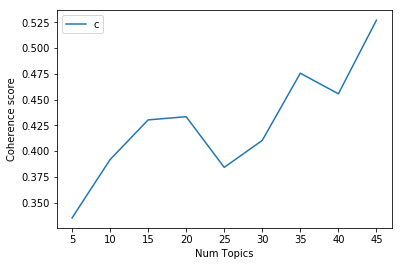

In [26]:
# Show graph
import matplotlib.pyplot as plt

plt.plot(topic_nums, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [72]:
# Running and Trainign LDA model using optimal number of topics based on coherence
m_ldamodel = Lda(m_doc_term_matrix, num_topics=9, id2word = m_dictionary, passes=10)
e_ldamodel = Lda(e_doc_term_matrix, num_topics=9, id2word = e_dictionary, passes=10)

#looking at raw topics
for topic in e_ldamodel.print_topics():
    print('\nTopic: ', topic[0], '\n', topic[1])



Topic:  0 
 0.070*"verizon" + 0.026*"people" + 0.020*"recommend" + 0.014*"company" + 0.013*"good" + 0.013*"family" + 0.013*"wireless" + 0.013*"extremely" + 0.013*"want" + 0.013*"plan"

Topic:  1 
 0.034*"best" + 0.026*"working" + 0.017*"service" + 0.017*"environment" + 0.017*"culture" + 0.017*"provides" + 0.017*"success" + 0.017*"good" + 0.012*"people" + 0.009*"company"

Topic:  2 
 0.072*"work" + 0.056*"place" + 0.035*"verizon" + 0.029*"would" + 0.029*"network" + 0.029*"best" + 0.020*"recommend" + 0.020*"10" + 0.011*"great" + 0.010*"environment"

Topic:  3 
 0.034*"verizon" + 0.025*"vzw" + 0.017*"brand" + 0.017*"care" + 0.017*"experience" + 0.017*"seems" + 0.017*"excellence" + 0.015*"good" + 0.012*"career" + 0.010*"great"

Topic:  4 
 0.069*"great" + 0.046*"company" + 0.031*"work" + 0.031*"employee" + 0.024*"benefit" + 0.016*"people" + 0.016*"year" + 0.016*"offer" + 0.016*"verizon" + 0.016*"awesome"

Topic:  5 
 0.027*"company" + 0.027*"learn" + 0.020*"work" + 0.020*"grow" + 0.020*"b

In [37]:
# Print topics and creating visualization
import pyLDAvis
from pyLDAvis import gensim

# manager model
#m_prepared_lda = pyLDAvis.gensim.prepare(m_ldamodel, m_doc_term_matrix, m_dictionary)
#pyLDAvis.display(m_prepared_lda)

# employee model
e_prepared_lda = pyLDAvis.gensim.prepare(e_ldamodel, e_doc_term_matrix, e_dictionary)
pyLDAvis.display(e_prepared_lda)


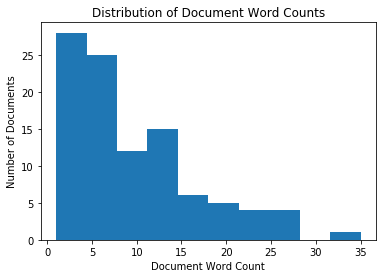

Mean: 10.0
Median: 7.0
Stdev: 7.0
1%ile: 1.0
99%ile: 26.0


In [60]:
# checking distribution of word counts within documents
doc_lens = [len(d) for d in e_corpus_trimmed]

# Plot
plt.hist(doc_lens)
plt.gca().set(ylabel='Number of Documents', xlabel='Document Word Count')
plt.title('Distribution of Document Word Counts')
plt.show()

print('Mean: '+str(round(np.mean(doc_lens))))
print('Median: ' + str(round(np.median(doc_lens))))
print('Stdev: ' + str(round(np.std(doc_lens))))
print('1%ile: ' + str(round(np.quantile(doc_lens, q=0.01))))
print('99%ile: ' + str(round(np.quantile(doc_lens, q=0.99))))

In [38]:
"""Block to begin creating dataset for analysis"""

# initialize pyLDAvis object with document-topic distribution
e_matrix = pyLDAvis.gensim._extract_data(e_ldamodel, e_doc_term_matrix, e_dictionary, doc_topic_dists=None)
m_matrix = pyLDAvis.gensim._extract_data(m_ldamodel, e_doc_term_matrix, e_dictionary, doc_topic_dists=None)

#function to create analytical dataset from topic modelling
def create_ADS(corpus, matrix, text, model):
    #create dictionary/dataframe with each document and corresponding topic distribution
    doc_topic_dict = {'doc': [], 't_dist': []}
    for d, t_dist in zip(corpus, matrix['doc_topic_dists']):
        doc_topic_dict['doc'].append(d)
        doc_topic_dict['t_dist'].append(t_dist)
        
    doc_topic_df = pd.DataFrame(doc_topic_dict)
    
    # get main topic for each document by finding ID of max probability
    doc_topic_df['main_topic'] = doc_topic_df['t_dist'].apply(lambda probs: np.argmax(probs))

    # get probability for main topic
    doc_topic_df['main_topic_prob'] = doc_topic_df['t_dist'].apply(lambda probs: max(probs))

    # create dictionary/dataframe with each topic and topic id to be merged with doc_topic_df
    topic_dict = {'topic_num': [], 'topic': []}
    for x in model.print_topics():
        topic_dict['topic_num'].append(x[0])
        topic_dict['topic'].append(x[1])
        
    topic_dict_df = pd.DataFrame(topic_dict)
    
    # create dictionary/dataframe with each topic and topic id to be merged with doc_topic_df
    topic_dict = {'topic_num': [], 'topic': []}
    for x in model.print_topics():
        topic_dict['topic_num'].append(x[0])
        topic_dict['topic'].append(x[1])
        
    topic_dict_df = pd.DataFrame(topic_dict)

    #create dictionary/dataframe with document to raw text map
    doc_text_dict = {'doc1': [], 'text': []}
    for d, t in zip(corpus, text):
        doc_text_dict['doc1'].append(d)
        doc_text_dict['text'].append(t)
        
    doc_text_dict_df = pd.DataFrame(doc_text_dict)
    #print(doc_text_dict_df.head())

    #merging dataframe with documents and main topics with dataframe with actual topics
    df1 = pd.merge(doc_topic_df, topic_dict_df,
                        left_on='main_topic', right_on='topic_num',
                        how='left')

    # adding raw text to dataframe
    df2 = pd.concat([df1, doc_text_dict_df], axis=1)

    # selecting desired columns
    analytical_dataset = df2[['text', 'doc', 'main_topic', 'main_topic_prob', 'topic', 't_dist']]
        
    return analytical_dataset

e_final_df = create_ADS(corpus = e_corpus_trimmed, matrix = e_matrix, text = e_text, model = e_ldamodel)
m_final_df = create_ADS(corpus = m_corpus_trimmed, matrix = m_matrix, text = m_text, model = m_ldamodel)

print(e_final_df.head())

                                                text  \
0  Not sure if this question is asking me If I wo...   
1  We have opportunities to grow our careers by m...   
2                     I recommend Verizon every day!   
3  College tuition programs like MADE and compens...   
4  Awesome place to work my coworkers are great t...   

                                                 doc  main_topic  \
0  [sure, question, asking, would, recommend, ver...           6   
1  [opportunity, grow, career, moving, within, ch...           5   
2                   [recommend, verizon, every, day]           7   
3  [college, tuition, program, like, made, compen...           2   
4  [awesome, place, work, coworkers, great, colla...           1   

   main_topic_prob                                              topic  \
0         0.961933  0.091*"great" + 0.053*"company" + 0.047*"work"...   
1         0.945289  0.046*"opportunity" + 0.030*"grow" + 0.023*"be...   
2         0.824941  0.077*"verizon"

In [41]:
# adding sentiment from text blob

from textblob import TextBlob as tb

def sentiment(text):
    t_review = tb(text)
    review_sentiment = t_review.sentiment.polarity
    return review_sentiment 

e_final_df['e_sentiment'] = e_final_df['text'].apply(lambda review: sentiment(review))
m_final_df['m_sentiment'] = m_final_df['text'].apply(lambda review: sentiment(review))

print(e_final_df.head())

                                                text  \
0  Not sure if this question is asking me If I wo...   
1  We have opportunities to grow our careers by m...   
2                     I recommend Verizon every day!   
3  College tuition programs like MADE and compens...   
4  Awesome place to work my coworkers are great t...   

                                                 doc  main_topic  \
0  [sure, question, asking, would, recommend, ver...           6   
1  [opportunity, grow, career, moving, within, ch...           5   
2                   [recommend, verizon, every, day]           7   
3  [college, tuition, program, like, made, compen...           2   
4  [awesome, place, work, coworkers, great, colla...           1   

   main_topic_prob                                              topic  \
0         0.961933  0.091*"great" + 0.053*"company" + 0.047*"work"...   
1         0.945289  0.046*"opportunity" + 0.030*"grow" + 0.023*"be...   
2         0.824941  0.077*"verizon"

In [ ]:
#write ADS to csv
def tocsv(df, csv):
    with open(csv, 'a', newline='') as f:
        df.to_csv(f, header=True)

tocsv(df = e_final_df, csv = 'e_csv.csv')
tocsv(df = m_final_df, csv = 'm_csv.csv')

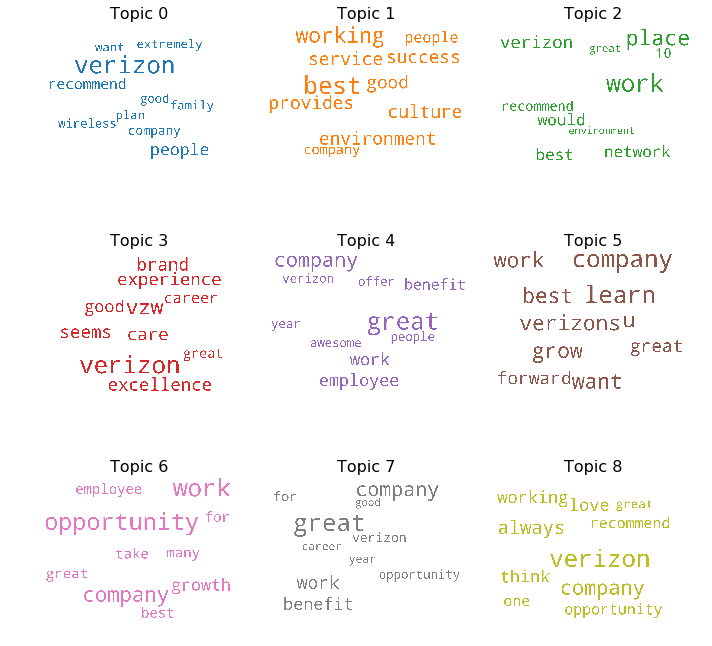

In [86]:
"""Creating wordclouds for each topic"""

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = e_ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

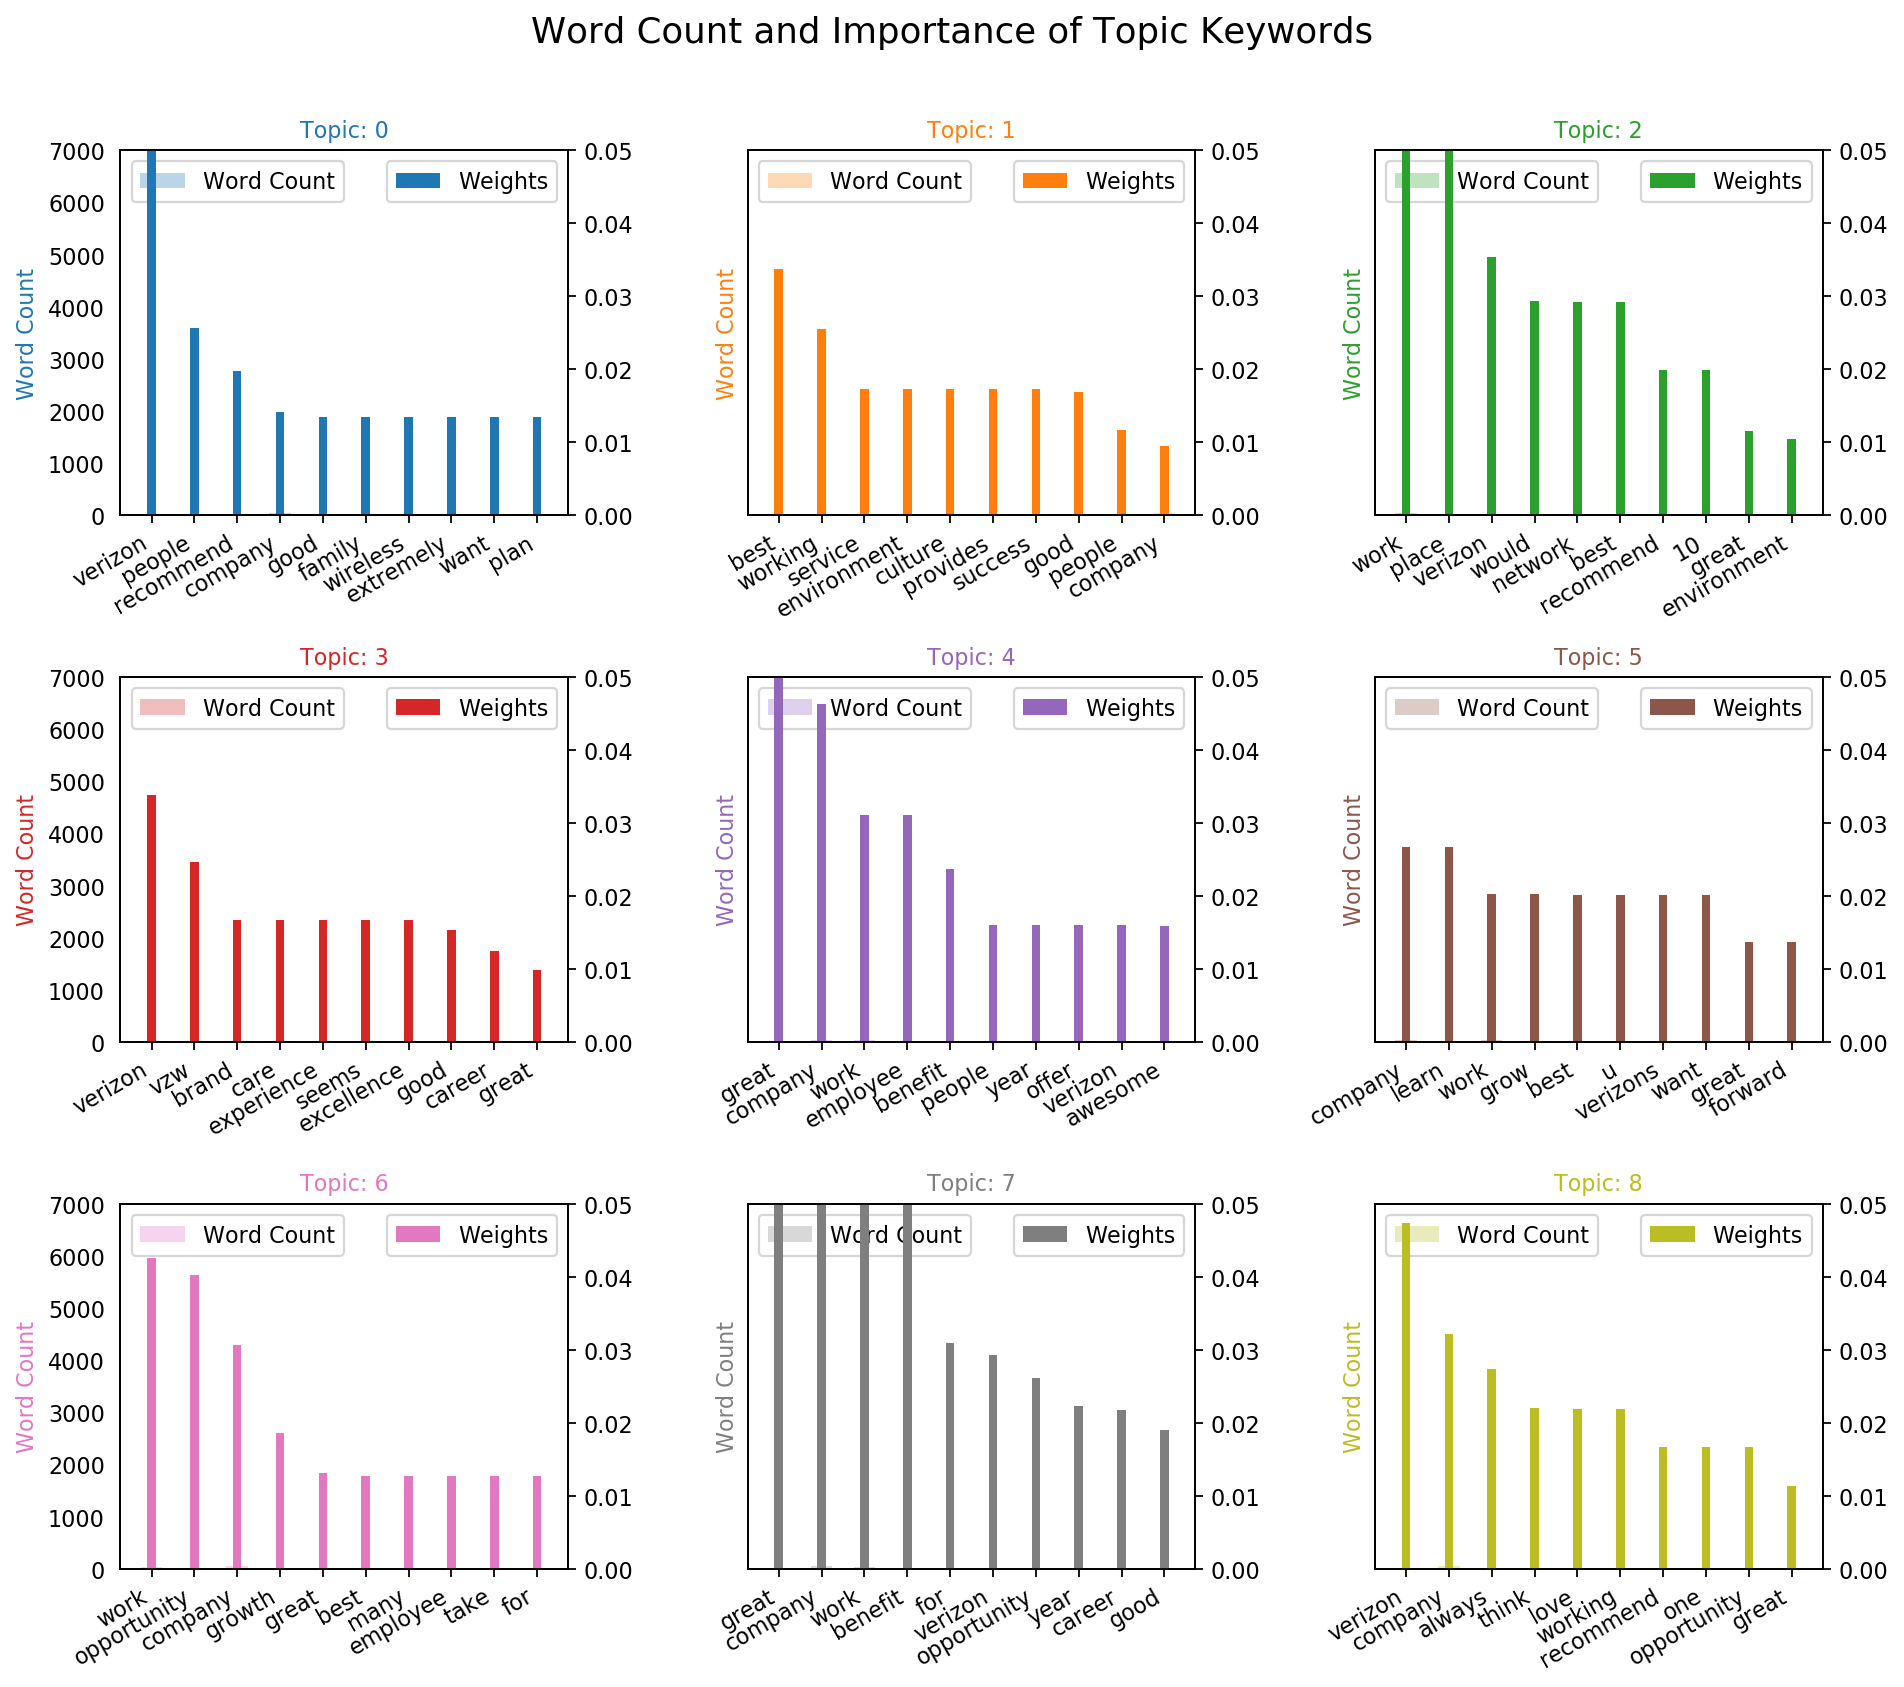

In [109]:
# Word counts for topics 
from collections import Counter
topics = e_ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in e_corpus_trimmed for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(12,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.05); ax.set_ylim(0, 7000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=16, y=1.05)    
plt.show()